<a href="https://colab.research.google.com/github/myresearch-ai/Deep-Learning-CNN-Demo-with-PyTorch/blob/main/1_1_PyTorch_CNN_Tutorial_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **PyTorch Made Easy!**
### **Standalone Implementiion of a Simple CNN in PyTorch using the nn.Module & nn.Sequential() approaches in Colab**

---




This notebook demonstrates how to create a **simple Convolutional Neural Network model** in PyTorch and train it to **recognize handwritten digits in the MNIST dataset.**
1. Import required PyTorch libraries
2. Define the Transformer
3. Load the dataset
4. Inspect and Visualization samples of the data (image/s)
5. Create the DataLoader object for loading batches of images
6. Build (and train) our model using nn.Module
8. Build (and train) our model using nn.Sequential
9. `nn.Model` vs `nn.Sequential`: When should you use either method?
9. Dataset: Structuring your data from your own files

Since its release in September of 2016, PyTorch has steadily evolved into a competitve choice within academic research & industry - Thanks to **Facebook AI Research Lab (FAIR)**. I personally have adopted PyTorch among my research tools for implementing neural network models efficiently. In this demo, I plan to provide some useful insights that will help the reader quickly become efficient with implementing complex models using PyTorch. But before proceeding with the rest of the content, it's beneficial to establish the benefits of adopting this framework.

#### **Why PyTorch**

---
What motivates the selection of a framework for building a machine learning model or more precisely, a neural network? I claim the that any answer to this question should begin by first identifying whether a model is intended for research or deployment to a production system. The points below summarize features of PyTorch that make it suitable for either research or production (industry):

##### **Core Features**:

- Supports mobile deployment: Industry 4.0.
- Strong support from the open source community & FAIR: Continuous improvements.
- Scalable & multiplatform support. 
- Support for single or multiple GPUs (and CPUs)

##### **Other Features**:
- Flexibility: The `nn.Module` provides a flexible interface to implement custom layers. This is great for research.
- Rapid Prototyping: `nn.Sequential` simplifies implementation of complex NNs with layers in a cascading fashion. This is ideal for most industry applications (production systems).
- Pythonic! PyTorch has a natural Python feel to it hence easy to master.
- It's backprop implementation is based on reverse accumulation which is more efficient compared to forward accumulation. This promotes efficiency of complex computations.
- Builds implicit dynamic computation graphs.
- Finally, PyTorch is an auto-differentiation framework. This simplifies complex low-level implementations.
  

**1. LIBRARIES & MODULES**

In [1]:
# Import PyTorch
import torch
# Import torchvision to get our dataset & useful image transformations
import torchvision
from torchvision.transforms import transforms
# Import PyTorch's optimization library & nn
# nn is used as the basic building block for constructing our network architecture
import torch.optim as optim
# Import PyTorch's modules for building model
import torch.nn as nn
import torch.nn.functional as F
# Import PyTorch module for creation of PyTorch compatible data from local files
from torch.utils.data import Dataset
# Plotting tools
import matplotlib.pyplot as plt
# System access and other tools
import os
from PIL import Image
import numpy as np

# Check if we are using GPU
print(f"GPU available: {torch.cuda.is_available()}")

GPU available: True


If GPU is available set device = `'cuda'` if not set device = `'cpu'`

In [2]:
# Setting computational device to GPU or CPU based on availability
# This is convenient! Same code works on either GPU or CPU!
if torch.cuda.is_available():
  device = "cuda"
  print("GPU is available & device set to use it.")
else:
  device = "cpu"
  print("GPU is unavailable & device set to cpu.")

GPU is available & device set to use it.


**2. Define The Transformer Pipeline**

In [3]:
# Transform to a PyTorch tensor & normalize values to [-1, +1]
# You can chain more transformations to this pipeline with minimal code
transform = transforms.Compose([transforms.ToTensor(),
                               transforms.Normalize((0.5), (0.5))])

**3. Fetch MNIST data using torchvision**

In [4]:
# Load training data & pass the transform pipeline to preprocess it
trainset = torchvision.datasets.MNIST("mnist",
                                      train = True,
                                      download = True,
                                      transform = transform)

# Load test data & pass the transform pipeline to preprocess it
testset = torchvision.datasets.MNIST("mnist",
                                     train = False,
                                     download = True,
                                     transform = transform)

**4. Visual inspection of data**

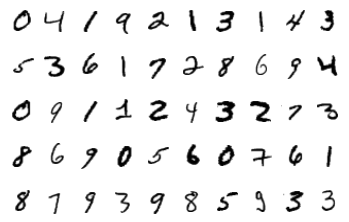

In [5]:
figure = plt.figure()
num_of_images = 50

for index in range(1, num_of_images+1):
  plt.subplot(5, 10, index)
  plt.axis("off")
  plt.imshow(trainset.data[index], cmap = "gray_r")

**5. Create our Data Loader**

In [6]:
# Prepare train & test loader
# Prepackaged data (MNIST etc) are already compatible with framework. This is
# will NOT work directly with your own data w/o intermediate manipulation
# Refer to section 9 for how we manipulate personal data for compatibility
torch.manual_seed(292)
trainloader = torch.utils.data.DataLoader(trainset,
                                          batch_size = 128,
                                          shuffle = True,
                                          num_workers = 0)

testloader = torch.utils.data.DataLoader(testset,
                                         batch_size = 128,
                                         shuffle = False,
                                         num_workers = 0)

**6. Build Model**: Subclassing `nn.Module`

In [7]:
class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    # Define layer objects
    self.conv1 = nn.Conv2d(in_channels = 1, 
                           out_channels = 32, 
                           kernel_size = 5, 
                           padding = 2)
    self.conv2 = nn.Conv2d(in_channels = 32, 
                           out_channels = 64, 
                           kernel_size = 5,
                           padding = 2)
    self.pool1 = nn.MaxPool2d(kernel_size=2)
    self.pool2  = nn.MaxPool2d(kernel_size=2)
    self.fc1   = nn.Linear(3136, 1024)
    self.fc2   = nn.Linear(1024, 10)
    self.dropout = nn.Dropout(p=0.5)

  def forward(self, x):
    # Define forward propagation sequence
    # Remember it's Conv1 - Relu - Max Pool - Conv2 - Relu - Max Pool - Flatten 
    # - FC1 - Relu - Dropout - FC2
    x = F.relu(self.conv1(x))
    x = self.pool1(x)
    x = F.relu(self.conv2(x))
    x = self.pool2(x)
    # Flatten
    x = x.view(-1, 3136)
    x = F.relu(self.fc1(x))
    x = self.dropout(x)
    x = self.fc2(x)

    return x

In [8]:
# Create an instance of the model and move it (memory and operations) to the CUDA device
net = Net()
net.to(device)

Net(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=3136, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=10, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

**6.1. Define Loss Function**

In [9]:
criterion = nn.CrossEntropyLoss()
# For our gradient descent algorthim or Optimizer
# We use Adam with a learning rate of 0.001
optimizer = optim.Adam(net.parameters(), lr=0.001)

**6.2. Training The Model**

In [10]:
# Define a convenient function to train PyTorch models with
# both nn.Model and nn.Sequential
def train(model, num_epochs, train_loader, test_loader):
    epoch_log = []
    loss_log  = []
    accuracy_log = []
    
    for epoch in range(num_epochs):
        print(f"Starting Epoch: {epoch + 1}...")
        running_loss = 0.0
        for i, data in enumerate(train_loader, 0):
            inputs, labels = data
            #Move our data to device
            inputs = inputs.to(device)
            labels = labels.to(device)
            # Clear gradients before training
            optimizer.zero_grad()
            # Forward -> backprop + optimize
            outputs = model(inputs) # Forward prop
            loss = criterion(outputs, labels) # Get loss
            loss.backward() # Backprop loss
            optimizer.step() # Update gradients

            # Print Training statistics - Epoch/Iterations/Loss/Accuracy
            running_loss += loss.item()
            if i % 50 == 49:
                correct = 0
                total   = 0
                with torch.no_grad():
                    for data in test_loader:
                        images, labels = data
                        # Move our data to GPU
                        images = images.to(device)
                        labels = labels.to(device)
                        # Foward propagate our test data batch through our model
                        outputs = model(images)
                        _, predicted = torch.max(outputs.data, dim = 1)
                        # Keep adding the label size or length to the total variable
                        total += labels.size(0)
                        # Keep a running total of the number of predictions predicted correctly
                        correct += (predicted == labels).sum().item()
                    accuracy = 100 * correct / total
                    epoch_num = epoch + 1
                    actual_loss = running_loss / 50
                    print(f'Epoch: {epoch_num}, Mini-Batches Completed: {(i+1)}, Loss: {actual_loss:.3f}, Test Accuracy = {accuracy:.3f}%')
                    running_loss = 0.0

        # Store training stats after each epoch
        epoch_log.append(epoch_num)
        loss_log.append(actual_loss)
        accuracy_log.append(accuracy)

    print('Finished Training')

In [11]:
train(model=net, num_epochs=10, train_loader=trainloader, test_loader=testloader)

Starting Epoch: 1...
Epoch: 1, Mini-Batches Completed: 50, Loss: 0.693, Test Accuracy = 94.040%
Epoch: 1, Mini-Batches Completed: 100, Loss: 0.175, Test Accuracy = 96.590%
Epoch: 1, Mini-Batches Completed: 150, Loss: 0.119, Test Accuracy = 97.110%
Epoch: 1, Mini-Batches Completed: 200, Loss: 0.095, Test Accuracy = 97.180%
Epoch: 1, Mini-Batches Completed: 250, Loss: 0.083, Test Accuracy = 98.050%
Epoch: 1, Mini-Batches Completed: 300, Loss: 0.074, Test Accuracy = 98.370%
Epoch: 1, Mini-Batches Completed: 350, Loss: 0.066, Test Accuracy = 98.220%
Epoch: 1, Mini-Batches Completed: 400, Loss: 0.064, Test Accuracy = 98.380%
Epoch: 1, Mini-Batches Completed: 450, Loss: 0.070, Test Accuracy = 98.260%
Starting Epoch: 2...
Epoch: 2, Mini-Batches Completed: 50, Loss: 0.055, Test Accuracy = 98.460%
Epoch: 2, Mini-Batches Completed: 100, Loss: 0.054, Test Accuracy = 98.590%
Epoch: 2, Mini-Batches Completed: 150, Loss: 0.051, Test Accuracy = 98.660%
Epoch: 2, Mini-Batches Completed: 200, Loss: 0.0

**7. Build Model**:`nn.Sequential`

In [12]:
model = nn.Sequential()
model.add_module(
    "conv1",
    nn.Conv2d(
        in_channels=1, out_channels=32,
        kernel_size=5, padding=2
    )
)
model.add_module("relu", nn.ReLU())
model.add_module("pool1", nn.MaxPool2d(kernel_size=2))
model.add_module(
    "conv2",
    nn.Conv2d(
        in_channels=32, out_channels=64,
        kernel_size=5, padding=2
    )
)
model.add_module("relu2", nn.ReLU())
model.add_module("pool2", nn.MaxPool2d(kernel_size=2))
model.add_module("flatten", nn.Flatten())
model.add_module("fc1", nn.Linear(3136, 1024))
model.add_module("relu3", nn.ReLU())
model.add_module("dropout", nn.Dropout(p=0.5))
model.add_module("fc2", nn.Linear(1024, 10))

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

if torch.cuda.is_available():
    model.cuda()

**7.1. Define Loss Function**

In [13]:
# We will resuse the previously defined loss function
pass

**7.2. Training The Model**

In [14]:
train(model=model, num_epochs=10, train_loader=trainloader, test_loader=testloader)

Starting Epoch: 1...
Epoch: 1, Mini-Batches Completed: 50, Loss: 0.757, Test Accuracy = 93.200%
Epoch: 1, Mini-Batches Completed: 100, Loss: 0.200, Test Accuracy = 95.620%
Epoch: 1, Mini-Batches Completed: 150, Loss: 0.140, Test Accuracy = 96.950%
Epoch: 1, Mini-Batches Completed: 200, Loss: 0.109, Test Accuracy = 97.090%
Epoch: 1, Mini-Batches Completed: 250, Loss: 0.099, Test Accuracy = 97.790%
Epoch: 1, Mini-Batches Completed: 300, Loss: 0.089, Test Accuracy = 97.670%
Epoch: 1, Mini-Batches Completed: 350, Loss: 0.076, Test Accuracy = 98.080%
Epoch: 1, Mini-Batches Completed: 400, Loss: 0.071, Test Accuracy = 98.020%
Epoch: 1, Mini-Batches Completed: 450, Loss: 0.065, Test Accuracy = 98.250%
Starting Epoch: 2...
Epoch: 2, Mini-Batches Completed: 50, Loss: 0.053, Test Accuracy = 98.500%
Epoch: 2, Mini-Batches Completed: 100, Loss: 0.051, Test Accuracy = 98.540%
Epoch: 2, Mini-Batches Completed: 150, Loss: 0.053, Test Accuracy = 98.090%
Epoch: 2, Mini-Batches Completed: 200, Loss: 0.0

**8. `nn.Model` vs. `nn.Sequential`**: **When to use one versus the other**

I must admit I struggled identifying the appropriate approach between the `nn.Module` & `nn.Sequential` approaches during my first days of learning PyTorch. To start with, the latter approach is the easiest of the two to define a cascading NN structure inside or outside an existing `nn.Module` - this is in fact the base class for all NN modules in [PyTorch](https://github.com/pytorch/pytorch/blob/master/torch/nn/modules/container.py#L29).

For more flexibility, example when implementing a new architecture of your own, you'd need to use the `nn.Module` which you'd subclass as demonstrated in section 6. Note that this approach at a minimum requires defining two methods: `__init__` to initialize & define the topology of your NN & the `forward` method which defines how components (layers) of your NN are linked. This method as implied is the forward pass of the data to the loss function. PyTorch is an auto-differentiation framework thus the framework handles the backward pass automatically. 

```
class NeuralNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(20, 10)
        self.fc2 = nn.Linear(10, 3)

    def forward(self, x)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return x
```

If flexibility is not required e.g. implementing a traditional architecture or perhaps we need to implement a rapid experiment or prototype model, the `nn.Sequential` approach is suitable. This approach as demonstrated in section 7 does not require implementing the `forward` pass method etc. as this is implicitly handled by the `nn.Sequential` class.


```
model = Sequential(
   nn.Linear(20, 10),
   nn.ReLU(),
   nn.Linear(10, 3),
   nn.Linear())
```

Alternatively, this can be implemented by inheriting the `nn.Sequential` class.



```
class NeuralNet(nn.Sequential):
    def __init__(self):
        super().__init__(
           nn.Linear(20, 10),
           nn.ReLU(),
           nn.Linear(10, 3),
           nn.ReLU())
```







**9. Dataset**:**Structuring your data from your own files**

We can iterate through the data directly but PyTorch provides an elegant and efficient method that arguably would be superior to direct iterations e.g. for loop. **DataLoader** provides an efficient, readable, customizable & automated batching approach. To take advantage of it, a dataset must be compatible with it. To maximize end-to-end efficiency of an ML solution, we should aim to optimize all code from data pre-processing to model pipelines. So far, we've done well implementing models in PyTorch to reap the benefits the framework provides. So how do we take advantage of these benefits during preprocessing? The answer is interestingly simple yet game-changing: We cast our data to a type compatible with the framework. We use the built-in method **Dataset** to achieve this. 

To demonstrate this clearly, I will mimick a real-world scenario where we have some image files (not using prepackaged & already processed images to a compatible type)

In [15]:
# Clone my repo with sample images of F15 & B777 jets
!git clone https://github.com/myresearch-ai/Deep-Learning-CNN-Demo-with-PyTorch.git

fatal: destination path 'Deep-Learning-CNN-Demo-with-PyTorch' already exists and is not an empty directory.


In [16]:
# cd into the repo to get the images for use
%cd Deep-Learning-CNN-Demo-with-PyTorch/sample_images/
# create a list of images 
img_list = sorted([img for img in os.listdir()])
print(img_list)

/content/Deep-Learning-CNN-Demo-with-PyTorch/sample_images
['777_1.JPG', '777_2.JPG', '777_3.JPG', 'f15_1.JPG', 'f15_2.JPG', 'f15_3.JPG']


Image shape: (205, 259, 3)
Image shape: (201, 247, 3)
Image shape: (204, 228, 3)
Image shape: (196, 298, 3)
Image shape: (204, 259, 3)
Image shape: (205, 266, 3)


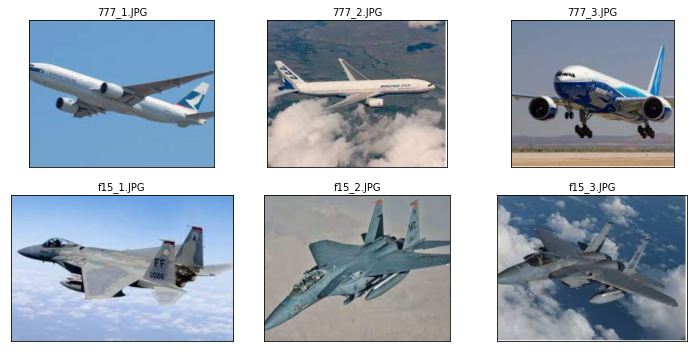

In [17]:
# Lets visualize our data
fig = plt.figure(figsize=(10, 5))
for i, image in enumerate(img_list):
  img = Image.open(image)
  print(f"Image shape: {np.array(img).shape}")
  ax = fig.add_subplot(2, 3, i+1)
  ax.set_xticks([])
  ax.set_yticks([])
  ax.imshow(img)
  ax.set_title(os.path.basename(image), size = 10)
plt.tight_layout()
plt.show()

In [18]:
labels = [1 if "f15" in os.path.basename(image) else 0 for image in img_list]
print(labels)

[0, 0, 0, 1, 1, 1]


As previously mentioned, to be able to leverage PyTorch built in DataLoader - a highly optimized module that allows fast iteration through batches of data & provides an elagant mechanism to allow data to flow through a pipeline of pre-defined transformations, 



```
tranform = transforms.Compose([
           transfroms.ToTensor(),
           transforms.Resize((height, width))])
```



we must cast data to a compatible structure & type. Now that we have a list of images (data) & a list of associated labels we derived from individual filenames, we can subclass the **Dataset** module as follows:

In [19]:
class MyImageData(Dataset):
  def __init__(self, img_list, labels, transform = None):
     self.img_list = img_list
     self.labels = labels
     self.transform = transform

  def __getitem__(self, idx):
    img = Image.open(self.img_list[idx])
    if self.transform != None:
      img = self.transform(img)
    label = self.labels[idx]
    return img, label

  def __len__(self):
    return len(self.labels)

In [20]:
# Now we can structure the code as we did before for preprocessing and modeling..
sample_dataset = MyImageData(img_list, labels)
for i, data in enumerate(sample_dataset):
  #Extract image and associated label
  img, label = data
  print(img, label)
  # Now you can do the rest as we did before CONVENIENTLY with prepackaged MNIST

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=259x205 at 0x7FB1F11B7090> 0
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=247x201 at 0x7FB1F11B7790> 0
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=228x204 at 0x7FB1F11B77D0> 0
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=298x196 at 0x7FB1F11B7B50> 1
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=259x204 at 0x7FB1F11B7D50> 1
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=266x205 at 0x7FB1F11B7F90> 1
